In [1]:
install.packages('MittagLeffleR')
library(MittagLeffleR)

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [2]:
x = rml(500, 0.3)
logMomentEstimator(x)

nu     delta      nuLo      nuHi   deltaLo   deltaHi 
0.3126575 1.4483783 0.2889100 0.3364050 0.7301148 2.1666417

In [3]:
dens <- function(alpha) {
    function(x) {
        (sin(pi*alpha) * x^(alpha - 1)) / (pi * (1 + x^(2*alpha) + 2*x^(alpha)*cos(pi*alpha)))
    }
}

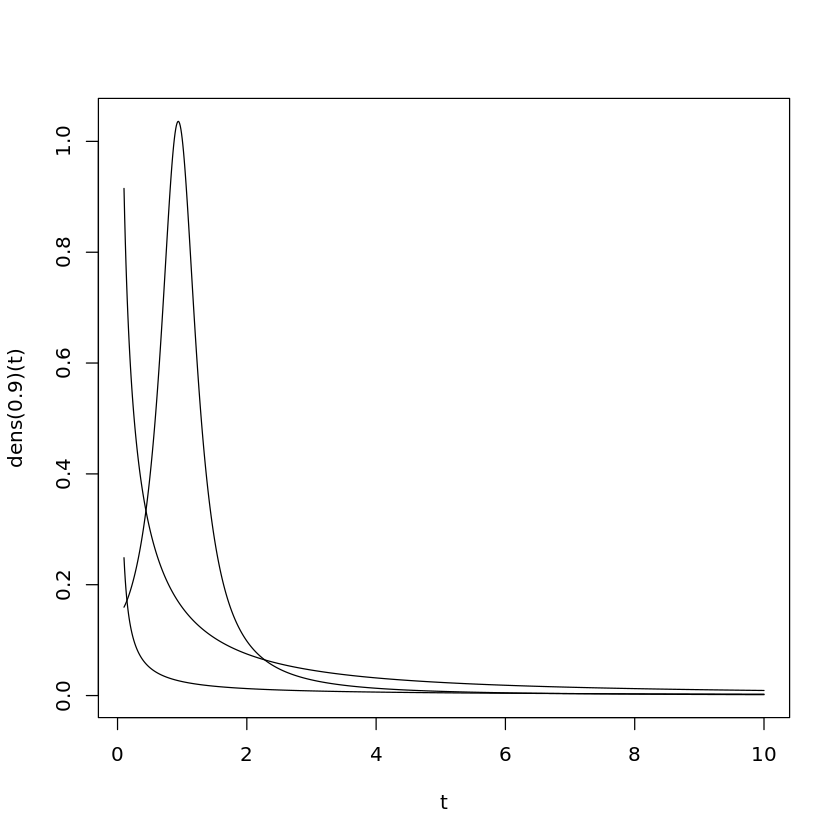

In [4]:
t = seq(0.1,10,0.01)
plot(t, dens(0.9)(t), type='l')
lines(t, dens(0.5)(t))
lines(t, dens(0.1)(t))

In [5]:
computeG <- function(lambda, w, x) {
    n = length(x); k = length(w)
    G = matrix(nrow = n, ncol = k)
    for (i in 1:n) {
        for (j in 1:k) {
            G[i,j] = w[j]*lambda[j]*exp(-x[i]*lambda[j])
        }
        if (sum(G[i,]) != 0) {
            G[i,] = G[i,] / sum(G[i,])
        }
    }
    G
}

In [6]:
EM <- function(x) {
    n = length(x)
    k = 20
    lambda = runif(k, 0, 10)
    w = rep(1/k, k)
    G = matrix(nrow = n, ncol = k)
    iterations = 10
    for (i in 1:iterations) {
        # computing G
        G = computeG(lambda, w, x)
        # recomputing weights
        w = colSums(G) / n
        lambda = colSums(G) / (x %*% G)
    }
    list(lambda, w)
}

In [7]:
n = 100
x = rml(n, 0.5)
EM(x)

0.6422512,0.000224032,3.627749,3.997422,23.83289,4.091678,0.03787619,42.91239,3.779678,4.651774,0.4195147,45.41481,30.74355,15.71916,2.293925,2.037959,2.423779,542.0875,3.758995,4.670329
